# Diagnostic of SED fitting
    

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib as mpl
import astropy
import scipy.stats as stats
from scipy.stats import linregress, lognorm,gaussian_kde
import itertools
import sys
from matplotlib.ticker import MultipleLocator,FormatStrFormatter
from astropy.table import Column, Table, join
from math import log10, sqrt


def plot_mock(name,estimated,exact,estimated_err, markersize, alpha_val1, alpha_val2, title_text,xlim_min, xlim_max,ylim_min, ylim_max,fit_line,oneTOone, color):
 
    # Calculate the point density
    xy = np.vstack([estimated,exact])
    z = gaussian_kde(xy)(xy)
    
    idx = z.argsort()
    estimated, exact, z = estimated[idx], exact[idx], z[idx]

    scatter_kwargs = {"zorder":100}
    error_kwargs = {"lw":.5, "zorder":0}

    name.scatter(estimated,exact, c=z, s=markersize, edgecolor='',alpha=1,**scatter_kwargs)   
    name.errorbar(estimated,exact,0, estimated_err, '-*',markersize=0.5,c='gray',linestyle='', alpha=alpha_val1, **error_kwargs)
  
    name.set_ylim(ylim_min, ylim_max)
    name.set_xlim(xlim_min, xlim_max)
    name.title.set_text(title_text)
    xaxis = np.linspace(xlim_min, xlim_max,2)
    a,b,Pr,c,d=linregress(estimated,exact)
    
    
    if (fit_line==1):
        fit = np.polyfit(estimated,exact, deg=1)
        xaxis = np.linspace(xlim_min, xlim_max,2)
        yaxis = (xaxis*fit[0]+fit[1])
        name.plot(xaxis,yaxis,'-s',c='black',linewidth=2,linestyle=':',)
  

    if (oneTOone==1):
        yaxis = xaxis
        name.plot(xaxis,yaxis,'-s',c='red',linewidth=3,linestyle='-',label='1:1')
        fit_result = mlines.Line2D([], [], c='red',linewidth=3,linestyle='-',label='1:1')
        Pearson_result = mlines.Line2D([], [], c='black',linewidth=2,linestyle=':',label='r= %.4f \ny=%.2f*x %+.2f'%(Pr,fit[0],fit[1]))
        handles_MS = [Pearson_result,fit_result]
        labels = [h.get_label() for h in handles_MS]  
        name.legend(handles=handles_MS, labels=labels,loc='best',frameon=False, fontsize =20,markerscale=0.8) 
        
def plot_histo(name,data,bins_no, range_min, range_max, multiloc, label_text, label_size):

    name.hist(data,bins_no, range=(range_min,range_max),normed=True,color="steelblue", edgecolor="steelblue", linewidth=3)
    name.yaxis.set_major_locator(plt.MultipleLocator(multiloc))
    name.set_xlabel(label_text, fontsize=label_size)
    
    return name


def plot_lognorm_fit(name, data,sigma_multiply_by, label_size):
    shape, loc, scale = stats.lognorm.fit(data, floc=0) 
    mu = np.log(scale) 
    sigma = shape 
    M = np.exp(mu) 
    s=np.sqrt(sigma) 

    x = np.linspace(min(data), max(data), num=400)
    name.plot(x, stats.lognorm.pdf(x, shape, loc=0, scale=scale), 'r', linewidth=3) 
    name.annotate('M = %.2f\ns = %.2f' % (M, s), xy=(1, 0), xycoords='axes fraction', fontsize=label_size, xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')
    name.axvline(x=(M+(sigma_multiply_by*s)), color='black', linestyle='--',linewidth=2)
     
    return name, M, s

def plot_MS(name,Mstar,SFR,SFR_err, Mstar_err, markersize, alpha_val1, alpha_val2, title_text,xlim_min, xlim_max,ylim_min, ylim_max,fit_line,color,bin_list):

    name.errorbar(Mstar,SFR,SFR_err, Mstar_err, '-*',markersize=1,c='gray',linewidth=2,linestyle='', alpha=alpha_val1)
    name.plot(Mstar,SFR,'-*',c=color,markersize=25,linestyle='', alpha=alpha_val2)
    name.set_ylim(ylim_min, ylim_max)
    name.set_xlim(xlim_min, xlim_max)
    name.title.set_text(title_text)

    for k in range(0,len(bin_list)-1):
        del tmp_xbin[:]
        del tmp_ybin[:]
        for l in range(0,len(Mstar)):
            if Mstar[l]>=bin_list[k] and Mstar[l]<bin_list[k+1]:
                tmp_xbin.append(Mstar[l])
                tmp_ybin.append(SFR[l])
        if len(tmp_xbin)>20:
            name.errorbar(np.mean(tmp_xbin),np.mean(tmp_ybin), yerr=np.std(tmp_ybin), xerr=np.std(tmp_xbin), marker='o', color='black',markersize=10,linewidth=3,linestyle='-',ecolor='black',zorder=3)
    if (fit_line==1):
        fit = np.polyfit(Mstar, SFR, deg=1)
        xaxis = np.linspace(xlim_min, xlim_max,2)
        yaxis = (xaxis*fit[0]+fit[1])
        name.plot(xaxis,yaxis,'-s',c='red',linewidth=2,linestyle='-',label='y=%.2f*x %+.2f'%(fit[0],fit[1]))
        fit_result = mlines.Line2D([], [], c='red',linewidth=2,linestyle='-',label='y=%.2f*x %+.2f'%(fit[0],fit[1]))
        handles_MS = [fit_result]
        labels = [h.get_label() for h in handles_MS]  
        name.legend(handles=handles_MS, labels=labels,loc='best',frameon=False, fontsize =20,markerscale=0.8) 


    return name


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['ytick.major.size'] = 15
plt.rcParams['ytick.minor.size'] = 6
plt.rcParams['ytick.minor.size'] = 6
plt.rc('legend',**{'fontsize':20})
plt.rc("font", size=20)
mpl.rc('lines', linewidth=8, color='gold', linestyle="-")

bbox_props = dict(boxstyle="round", fc="white", ec="blue", alpha=0.9, lw=1)
tmp_xbin, tmp_ybin=[],[]



## Mock analysis

The mock catalogue was generated to check the reliability of the computed parameters. To perform this test, we used an option included in CIGALE, which allows for a creation of mock objects for each galaxy. The final step of verification of estimated parameters is to run CIGALE on the simulated sample using the same set of input parameters as for the original catalogue and to compare the output physical parameters of the artificial catalogue with the real ones. 

Figure below presents the comparison of the output parameters of the mock catalogue created from the input parameters versus values estimated by the code for our real galaxy sample. The determinant value, which can characterise the reliability of the obtained values, is the Pearson product-moment correlation coefficient (r). The comparison between the results from the mock and real catalogues shows that CIGALE gives an excellent estimation of main physical parameters which we use for the final analysis (Ldust, Mstar and SFR).


/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater


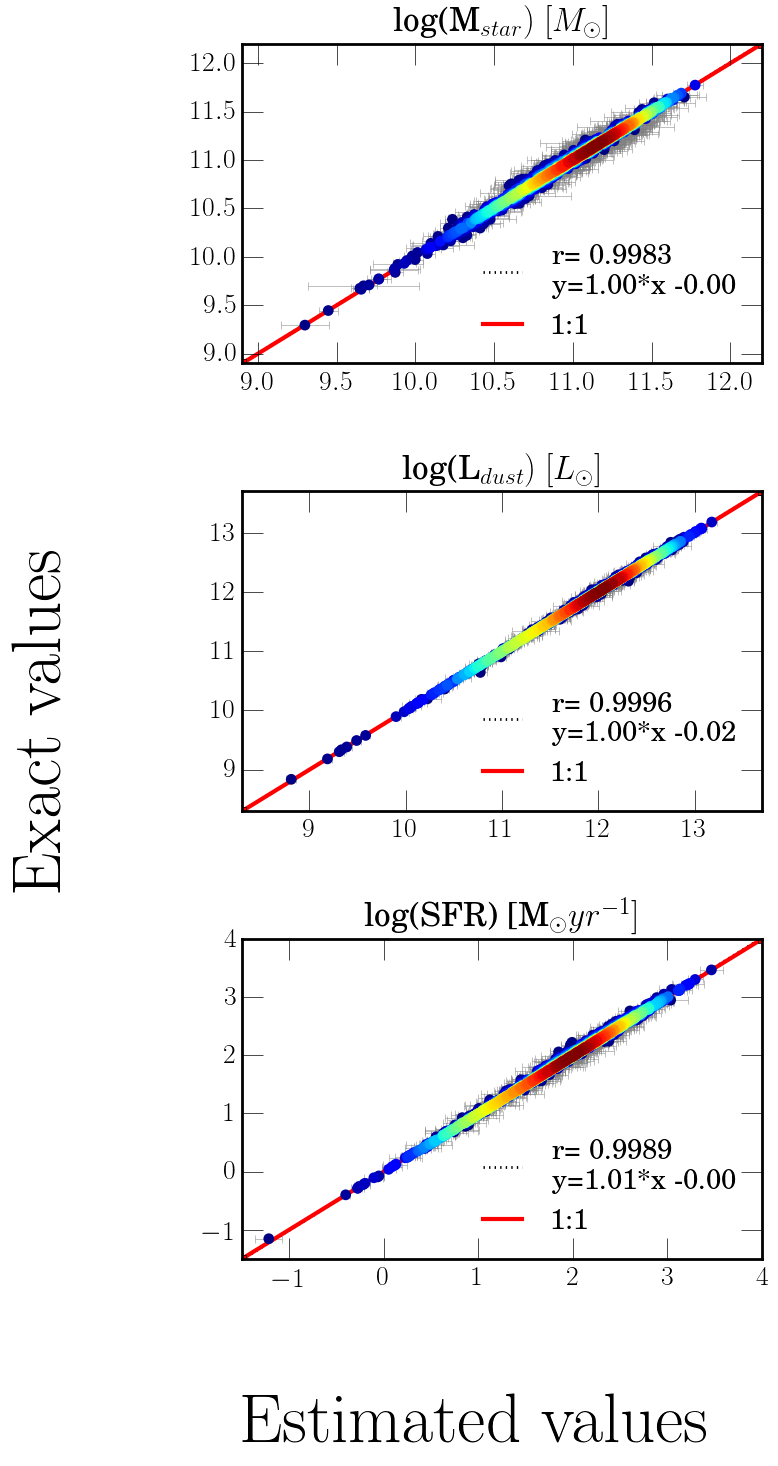

In [7]:
#################################################################################################
#################################################################################################
# MOCK 
#################################################################################################
#################################################################################################	

final = Table.read("results_mock.fits")
final.meta = None

font_label=20

f, ((plt1), (plt2), (plt3)) = plt.subplots(3,1,figsize=(8,15))
f.text(0.01, 0.5, r'$\rm Exact\mbox{ }values$', va='center', rotation='vertical',fontsize=50)
f.text(0.3, 0.03, r'$\rm Estimated\mbox{ }values $', va='center', fontsize=50)

plt.subplots_adjust(left=0.3, bottom=0.14, right=0.95, top=0.95, wspace=0.5, hspace=0.4)
mock_final=final[(final['bayes.stellar.m_star']>0)]
plt1 = plot_mock(plt1,np.log10(mock_final['bayes.stellar.m_star']),np.log10(mock_final['best.stellar.m_star']), mock_final['bayes.stellar.m_star_err']/mock_final['bayes.stellar.m_star'],60, 0.7, 0.7, 'log(M_{star})\mbox{ }[M_{\odot}]', 8.9, 12.2,8.9, 12.2, 1, 1, 'blue')
plt2 = plot_mock(plt2,np.log10(mock_final['bayes.dust.luminosity']/(3.846*pow(10,26))),np.log10(mock_final['best.dust.luminosity']/(3.846*pow(10,26))), mock_final['bayes.dust.luminosity_err']/mock_final['bayes.dust.luminosity'],60, 0.7, 0.7, 'log(L_{dust})\mbox{ }[L_{\odot}]', 8.3, 13.7,8.3, 13.7, 1, 1, 'blue')
plt3 = plot_mock(plt3,np.log10(mock_final['bayes.sfh.sfr10Myrs']),np.log10(mock_final['best.sfh.sfr10Myrs']), mock_final['bayes.sfh.sfr10Myrs_err']/mock_final['bayes.sfh.sfr10Myrs'],60, 0.7, 0.7, 'log(SFR)\mbox{ }[M_{\odot}yr^{-1}]', -1.5, 4,-1.5, 4, 1, 1, 'blue')

plt.show()


## Quality of the SED fitting

The quality of the fitted SEDs is calculated making use of the $\chi^2$ value of the best model, marginalised over all parameters except the one assigned for the further physical analysis. The final output values of analysed parameters are calculated as the mean and standard deviation determined from the PDFs.

The distribution of the standard $\chi^2$ is shown in figure below (left bottom panel). To obtain the threshold value of the chi2 we fitted the lognormal distribution, and we found mean value and sigma, and we calculated the threshold as mean + 3sigma. 

After visual inspection we have found galaxies with $\chi^2$ lower then threshold but with the wrong fit for dust or stellar part of the spectra. We decided to introduce two more $\chi^2$s values: one for optical part ($OPT\chi^2$), and one for infrared part of the spectra ($IR\chi^2$). We defined the wavelengh range for $OPT\chi^2$ and $IR\chi^2$ as < 8 um (in rest frame), and >=8 um (in rest frame),  respectively.
Distributions of both new $\chi^2s$ are shown in Figure below in the top panel. Again, we fitted lognormal distribution, and analogically we defined the thresholds ($OPT\chi^2_{threshold}$ and $IR\chi2_{threshold}$) as mean +4 sigma. 

We select the final sample according to the equation:
\begin{equation}
\rm {\chi^2 \leq \chi2_{threshold} \wedge OPTchi^2 \leq OPT\chi2_{threshold} \wedge IR\chi^2 \leq IRchi^2_{threshold} }
\end{equation}
This equation allows us to select only good fits for further analysis (or to search for interesting cases). 
Our final sample is shown in Figure below in right bottom panel.

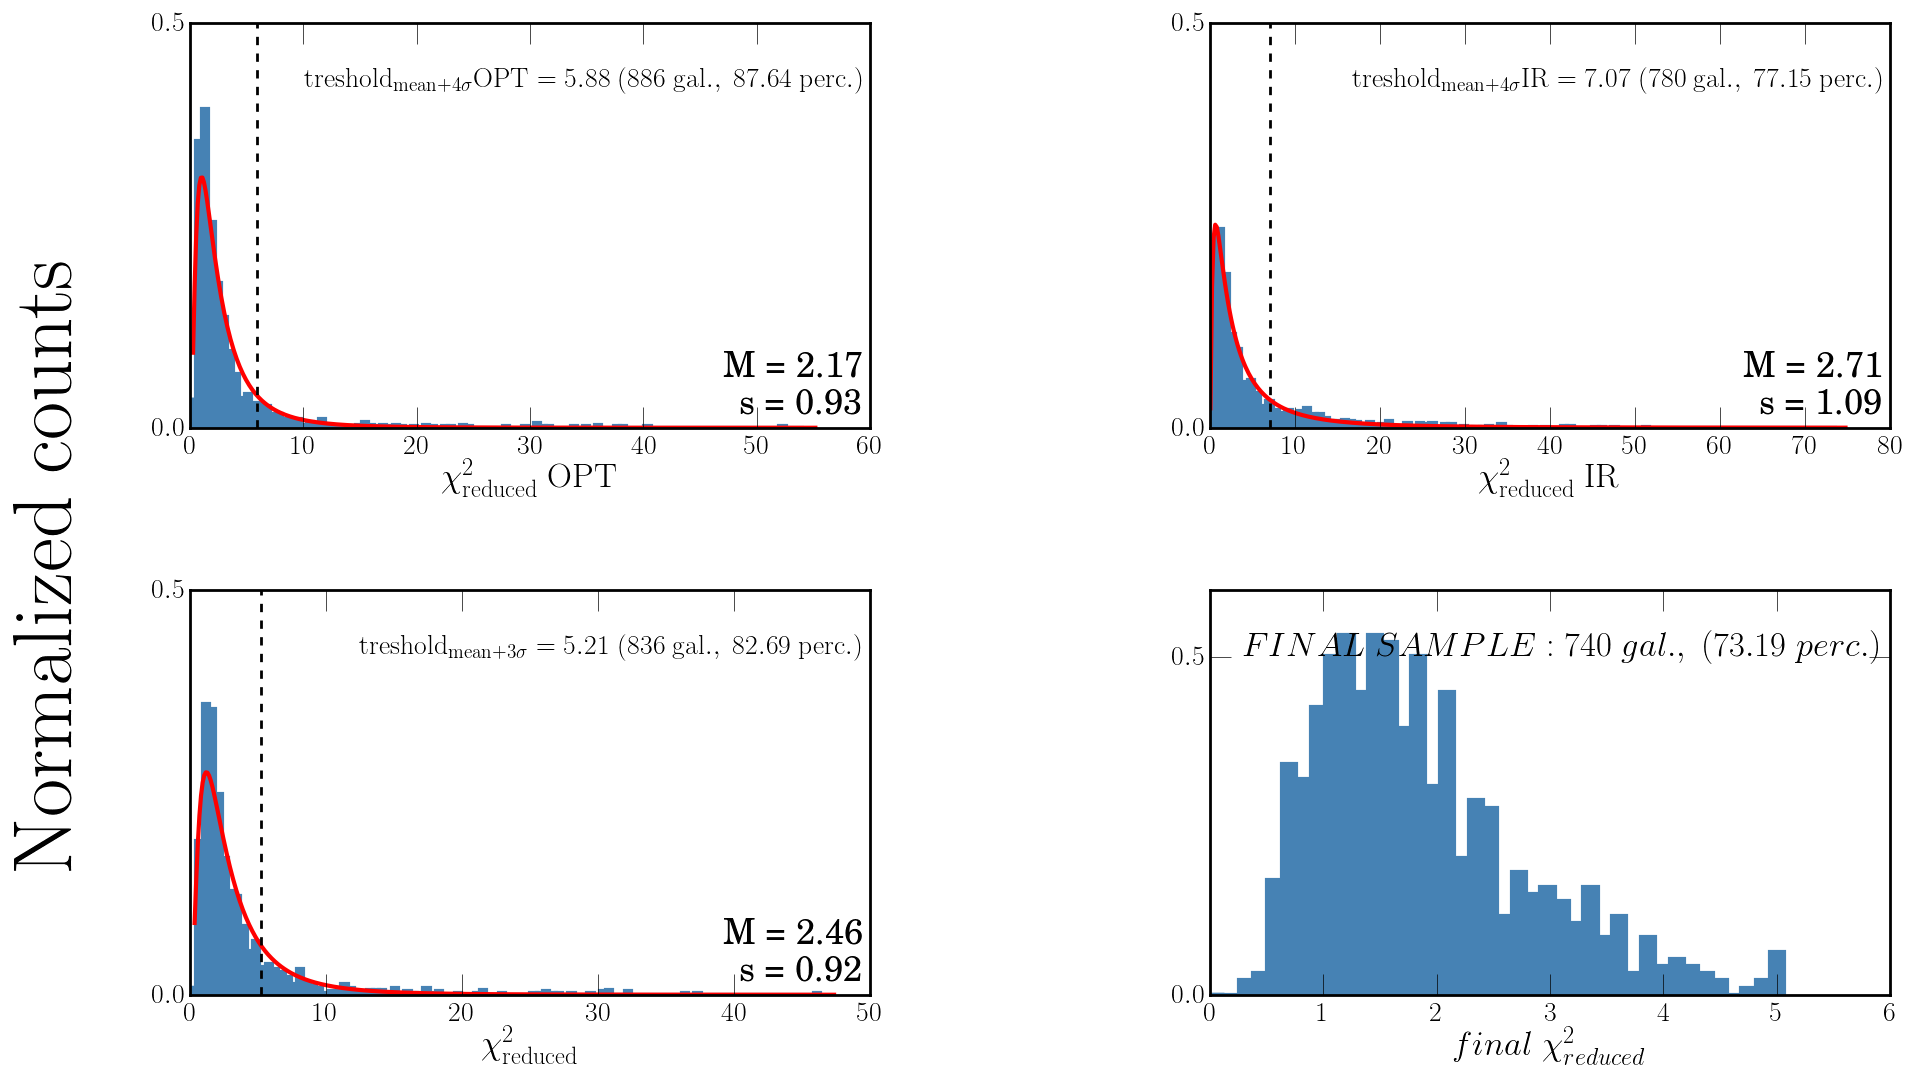

In [8]:

#################################################################################################
#################################################################################################
# RESULTS  - FULL SPECTRA
#################################################################################################
#################################################################################################	

final = Table.read("cosmos_final_results.fits")
final.meta = None
sigma_multiply_by_IR_OPT_chi2=4
sigma_multyply_by_main_chi2=3
font_label=25

f, ((plt1, plt2), (plt3,plt4)) = plt.subplots(2,2,figsize=(20,12))
f.text(0.01, 0.5, r'$\rm Normalized\mbox{ }counts$', va='center', rotation='vertical',fontsize=60)

plt.subplots_adjust(left=0.1, bottom=0.14, right=0.95, top=0.95, wspace=0.5, hspace=0.4)

plt1 = plot_histo(plt1,final['UVoptIR_OPTchi2'],100,0,max(final['UVoptIR_OPTchi2'])-1, 0.5, r"$\rm \chi^2_{reduced}\mbox{ }OPT$", font_label)
plt1, M, s = plot_lognorm_fit(plt1, final['UVoptIR_OPTchi2'] ,sigma_multiply_by_IR_OPT_chi2,font_label)
treshold_chi2_OPT=M+(sigma_multiply_by_IR_OPT_chi2*s)
plt1.annotate(r"$\rm treshold_{mean+ %s\sigma}OPT = %.2f \mbox{ }(%s\mbox{ } gal.,\mbox{ } %.2f\mbox{ }perc.)$" % (sigma_multiply_by_IR_OPT_chi2,M+(sigma_multiply_by_IR_OPT_chi2*s), len(final[final['UVoptIR_OPTchi2']<treshold_chi2_OPT]), len(final[final['UVoptIR_OPTchi2']<treshold_chi2_OPT])*100/len(final)), xy=(1, 0.8), xycoords='axes fraction', fontsize=20, xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')

plt2 = plot_histo(plt2,final['UVoptIR_IRchi2'],100,0,max(final['UVoptIR_IRchi2'])-1, 0.5, r"$\rm \chi^2_{reduced}\mbox{ }IR $", font_label)
plt2, M, s = plot_lognorm_fit(plt2, final['UVoptIR_IRchi2'] ,sigma_multiply_by_IR_OPT_chi2,font_label)
treshold_chi2_IR=M+(sigma_multiply_by_IR_OPT_chi2*s)
plt2.annotate(r"$\rm treshold_{mean+ %s\sigma}IR = %.2f \mbox{ }(%s\mbox{ } gal.,\mbox{ } %.2f\mbox{ }perc.)$" % (sigma_multiply_by_IR_OPT_chi2,M+(sigma_multiply_by_IR_OPT_chi2*s), len(final[final['UVoptIR_IRchi2']<treshold_chi2_IR]), len(final[final['UVoptIR_IRchi2']<treshold_chi2_IR])*100/len(final)), xy=(1, 0.8), xycoords='axes fraction', fontsize=20, xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')

plt3 = plot_histo(plt3,final['UVoptIR_best.reduced_chi_square'],100,0,max(final['UVoptIR_best.reduced_chi_square'])-1, 0.5, r"$\rm \chi^2_{reduced}$", font_label)
plt3, M, s = plot_lognorm_fit(plt3, final['UVoptIR_best.reduced_chi_square'] ,sigma_multyply_by_main_chi2,font_label)
treshold_chi2_global=M+(sigma_multyply_by_main_chi2*s)
plt3.annotate(r"$\rm treshold_{mean+ %s\sigma} = %.2f \mbox{ }(%s\mbox{ } gal.,\mbox{ } %.2f\mbox{ }perc.)$" % (sigma_multyply_by_main_chi2,M+(sigma_multyply_by_main_chi2*s), len(final[final['UVoptIR_best.reduced_chi_square']<treshold_chi2_global]), len(final[final['UVoptIR_best.reduced_chi_square']<treshold_chi2_global])*100/len(final)), xy=(1, 0.8), xycoords='axes fraction', fontsize=20, xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')

ok_final = final[(final['UVoptIR_best.reduced_chi_square']<treshold_chi2_global) & (final['UVoptIR_IRchi2']<treshold_chi2_IR) &  (final['UVoptIR_OPTchi2']<treshold_chi2_OPT)]

plt4 = plot_histo(plt4,ok_final['UVoptIR_best.reduced_chi_square'],40,0,max(ok_final['UVoptIR_best.reduced_chi_square']), 0.5,r"$final\mbox{ }\chi^2_{reduced}$" , font_label)
plt4.annotate(r"$ FINAL\mbox{ }SAMPLE: %s\mbox{ } gal.,\mbox{ } (%.2f\mbox{ }perc.)$"%(len(ok_final), len(ok_final)*100/len(final)), xy=(1, 0.8), xycoords='axes fraction', fontsize=25, xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')

plt.show()



## Comparison with SED fitting based on the FIR data only

We check our Ldust results by comparion with SED fitting based on the FIR data only (the same parameters were used but as a dataset only FIR data were introcuded).

Figure below shows a very goog comparison between both runs:



In [9]:
#################################################################################################
# Ldust full data set vs Ldust IRonly
#################################################################################################

fit_line=1
color='cyan'
bin_list=[7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25]

fig, plt1 = plt.subplots(figsize=(15,10))
plt.subplots_adjust(left=0.1, bottom=0.16, right=0.95, top=0.90, wspace=None, hspace=None)

#plt1 = plot_MS(plt1,ok_final['UVoptIR_logLdust'],ok_final['IR_logLdust'], ok_final['UVoptIR_logLdust_err'],ok_final['IR_logLdust_err'], 25, 0.3, 0.5,r"$\rm N=%s $"%len(ok_final),9.8,13.4,9.8, 13.4,fit_line,color,bin_list)
plt1 = plot_mock(plt1,ok_final['UVoptIR_logLdust'],ok_final['IR_logLdust'], ok_final['UVoptIR_logLdust_err'],ok_final['IR_logLdust_err'], 60, 0.7, 0.7,r"$\rm N=%s $"%len(ok_final),9.8,13.4,9.8, 13.4,fit_line,color,bin_list)
#plt1 = plot_mock(plt1,np.log10(mock_final['bayes.stellar.m_star']),np.log10(mock_final['best.stellar.m_star']), mock_final['bayes.stellar.m_star_err']/mock_final['bayes.stellar.m_star'],60, 0.7, 0.7, 'log(M_{star})\mbox{ }[M_{\odot}]', 9.8,13.4,9.8, 13.4, 1, 1, 'blue')
xline = np.linspace(9,14,2)
yline = (xline)
plt1.plot(xline,yline,'-s',c='black',linewidth=2, linestyle=':',label='1:1')
plt1.annotate(r"$\rm 1:1 $", xy=(0.1, 0.8), xycoords='axes fraction', fontsize=30, xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')


plt.xlabel(r'$\rm log(Ldust)_{all}\mbox{ }[M_{\odot}] $', fontsize=40)
plt.ylabel(r'$\rm log(Ldust)_{IRonly}\mbox{ }[M_{\odot}] $', fontsize=50)

plt.show()


TypeError: plot_mock() takes 15 positional arguments but 16 were given